# HUK Coburg Coding Challenge

## 01 | Setting up the environment

In [1]:
# Standard libraries
import os

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Model selection and evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, precision_recall_curve, PrecisionRecallDisplay, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


sns.set_palette(sns.color_palette("Dark2"))
RANDOM_STATE = 43

DATA_D01_FOLDER_PATH = "data/d01/"

df_per = pd.read_csv(os.path.join(DATA_D01_FOLDER_PATH, "alter_geschlecht.csv"))
df_int = pd.read_csv(os.path.join(DATA_D01_FOLDER_PATH, "interesse.csv"))
df_res = pd.read_csv(os.path.join(DATA_D01_FOLDER_PATH, "rest.csv"), sep=";")

print("Personal data shape: ", df_per.shape)
print("Interest data shape: ", df_int.shape)  # -> less observations
print("Rest data shape: ", df_res.shape)

Personal data shape:  (508146, 3)
Interest data shape:  (381109, 2)
Rest data shape:  (508146, 9)


| Variable Name   | Type       | Description                                                                 | Prior Assumption                                                                                   |
|-----------------|------------|-----------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| ID              | Integer    | Eindeutige ID des Kunden                                                    | Keine direkte Auswirkung auf Interesse                                                             |
| Geschlecht      | Categorical| Geschlecht des Kunden (z.B. männlich/weiblich)                              | Mögliche Unterschiede in der Affinität je nach Geschlecht                                           |
| Alter           | Integer    | Alter des Kunden in Jahren                                                  | Jüngere oder ältere Altersgruppen könnten unterschiedlich interessiert sein                        |
| Fahrerlaubnis   | Binary     | Ob der Kunde eine Fahrerlaubnis besitzt (Ja=1, Nein=0)                      | Kunden ohne Fahrerlaubnis zeigen vermutlich kein Interesse                                         |
| Regional_Code   | Float      | Eindeutiger Code der Wohnregion des Kunden                                  | Regionale Unterschiede könnten das Interesse beeinflussen                                          |
| Vorversicherung | Binary     | Ob der Kunde bereits eine Kfz-Versicherung hat (Ja=1, Nein=0)               | Kunden ohne Vorversicherung könnten eher interessiert sein                                         |
| Alter_Fzg       | String     | Alter des Fahrzeugs des Kunden ("1-2 Year" etc.)                            | Besitzer neuerer Fahrzeuge könnten eher Interesse zeigen                                           |
| Vorschaden      | Binary     | Ob der Kunde bereits einen Schaden am Fahrzeug hatte (Yes, No)              | Kunden mit Vorschäden könnten verstärktes Interesse an einem besseren Angebot haben                |
| Jahresbeitrag   | Float      | Erwarteter Jahresbeitrag in Euro bei Abschluss der Versicherung             | Höhere Beiträge könnten das Interesse negativ beeinflussen                                         |
| Vertriebskanal  | Float      | Code für den genutzten Vertriebskanal                                       | Bestimmte Vertriebskanäle könnten erfolgreicher im Wecken des Interesses sein                      |
| Kundentreue     | Integer    | Anzahl der Tage, seit denen eine Kundenbeziehung besteht                    | Längere Kundentreue könnte mit höherem Interesse korrelieren                                       |
| Interesse       | Binary     | Zielvariable: Ob der Kunde an einem Versicherungsangebot interessiert ist (Ja=1, Nein=0) | -                                                                                     |

**Checks:**
- ✅ All data sets only contain unique IDs
- ❓ Interest dataframe has less rows than the other dataframes --> assumption: missing values are test data since max interest id is 381109 (= length of interest dataframe)
- ✅ Otherwise no missing values in any dataframe
- ❌ How is this sample generated and who is the target group?
- ❓ `Jahresbeitrag` might be endogenous since it could had been calculated from the other variables

## 02 | Prepare the Data

In [2]:
LABEL = "Interesse"
CAT_FEATS = ["Geschlecht", "Fahrerlaubnis", "Regional_Code", "Vorversicherung", "Alter_Fzg", "Vorschaden", "Vertriebskanal"]
NUM_FEATS = ["Alter", "Jahresbeitrag", "Kundentreue"]

# Create dataframe that contains all entries with a label value
df_raw = pd.merge(pd.merge(df_int, df_per, on="id"), df_res, on="id")

# Create another dataframe that contains all entries with no label value
df_raw_no_label = pd.merge(df_per, df_res, on="id")
df_raw_no_label = df_raw_no_label[~df_raw_no_label["id"].isin(df_raw["id"])]

In [3]:
def preprocess_data(df: pd.DataFrame, test_df = False) -> pd.DataFrame:
    mapping_dict = {
        "Geschlecht": {"Male": 0, "Female": 1},
        "Vorschaden": {"No": 0, "Yes": 1},
        "Alter_Fzg": {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}
    }
    for col, mapping in mapping_dict.items():
        df[col] = df[col].map(mapping).astype("int8")
    int8_columns = ["Vorversicherung", "Alter", "Fahrerlaubnis", "Regional_Code"]
    df[int8_columns] = df[int8_columns].astype("int8")
    int16_columns = ["Vertriebskanal", "Kundentreue"]
    df[int16_columns] = df[int16_columns].astype("int16")
    if not test_df:
        df["Interesse"] = df["Interesse"].astype("int8")
    return df["id"], df.drop(columns="id")

df_ids, df = preprocess_data(df_raw.copy())
df_no_label_ids, df_no_label = preprocess_data(df_raw_no_label.copy(), test_df=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Interesse        381109 non-null  int8   
 1   Geschlecht       381109 non-null  int8   
 2   Alter            381109 non-null  int8   
 3   Fahrerlaubnis    381109 non-null  int8   
 4   Regional_Code    381109 non-null  int8   
 5   Vorversicherung  381109 non-null  int8   
 6   Alter_Fzg        381109 non-null  int8   
 7   Vorschaden       381109 non-null  int8   
 8   Jahresbeitrag    381109 non-null  float64
 9   Vertriebskanal   381109 non-null  int16  
 10  Kundentreue      381109 non-null  int16  
dtypes: float64(1), int16(2), int8(8)
memory usage: 7.3 MB


## 03 | Descriptive Statistics

In [5]:
df

,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,0,44,1,28,0,2,1,40454.0,26,217
1,0,0,76,1,3,0,1,0,33536.0,26,183
2,1,0,47,1,28,0,2,1,38294.0,26,27
3,0,0,21,1,11,1,0,0,28619.0,152,203
4,0,1,29,1,41,1,0,0,27496.0,152,39
...,...,...,...,...,...,...,...,...,...,...,...
381104,0,0,74,1,26,1,1,0,30170.0,26,88
381105,0,0,30,1,37,1,0,0,40016.0,152,131
381106,0,0,21,1,30,1,0,0,35118.0,160,161
381107,0,1,68,1,14,0,2,1,44617.0,124,74


In [6]:
df_descr = df.describe(include="all")
df_descr.loc["mode"] = df.mode().iloc[0]
df_descr.loc["nunique"] = df.nunique()
df_descr

,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.122563,0.459239,38.822584,0.997869,26.388807,0.458210,0.609616,0.504877,30564.389581,112.034295,154.347397
std,0.327936,0.498336,15.511611,0.046110,13.229888,0.498251,0.567439,0.499977,17213.155057,54.203995,83.671304
min,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,0.000000,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24405.000000,29.000000,82.000000
50%,0.000000,0.000000,36.000000,1.000000,28.000000,0.000000,1.000000,1.000000,31669.000000,133.000000,154.000000
75%,0.000000,1.000000,49.000000,1.000000,35.000000,1.000000,1.000000,1.000000,39400.000000,152.000000,227.000000
max,1.000000,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000
mode,0.000000,0.000000,24.000000,1.000000,28.000000,0.000000,1.000000,1.000000,2630.000000,152.000000,256.000000
nunique,2.000000,2.000000,66.000000,2.000000,53.000000,2.000000,3.000000,2.000000,48838.000000,155.000000,290.000000


**Key overall insights**
- The dataset contains 381,109 unique customers
- ~12.2% of customers are interested in an insurance offer (baseline)
- Minimum `Alterr` is 20, interesting since German driving license can be obtained at 18
- 99.8% of customers have a driving license `Fahrerlaubnis` (--> question: is the customer always the driver?)
- `Jahresbeitrag` looks strange:
  - Maximum value is ~0.5 million EUR (outlier)
  - Generally, for a yearly insurance fee the values are very high. Double checked with https://www.huk.de/tarifrechner/pkw/angebot (Lambo, high risk profile: max. ~40k EUR)

**Assumptions and Questions**
- `Jahresbeitrag` is either
  - Wrongly scaled (e.g. expected lifetime fee instead of yearly fee) --> *GOTO OPTION.* variable description explains "Erwarteter Versicherungsbeitrag bei Abschluss in €", i.e. not mentioning "yearly"
  - Wrongly recorded (e.g. in a different currency)
  - Wrong units (e.g. cents instead of full EUR)

### 03.1 | Categorical Variables

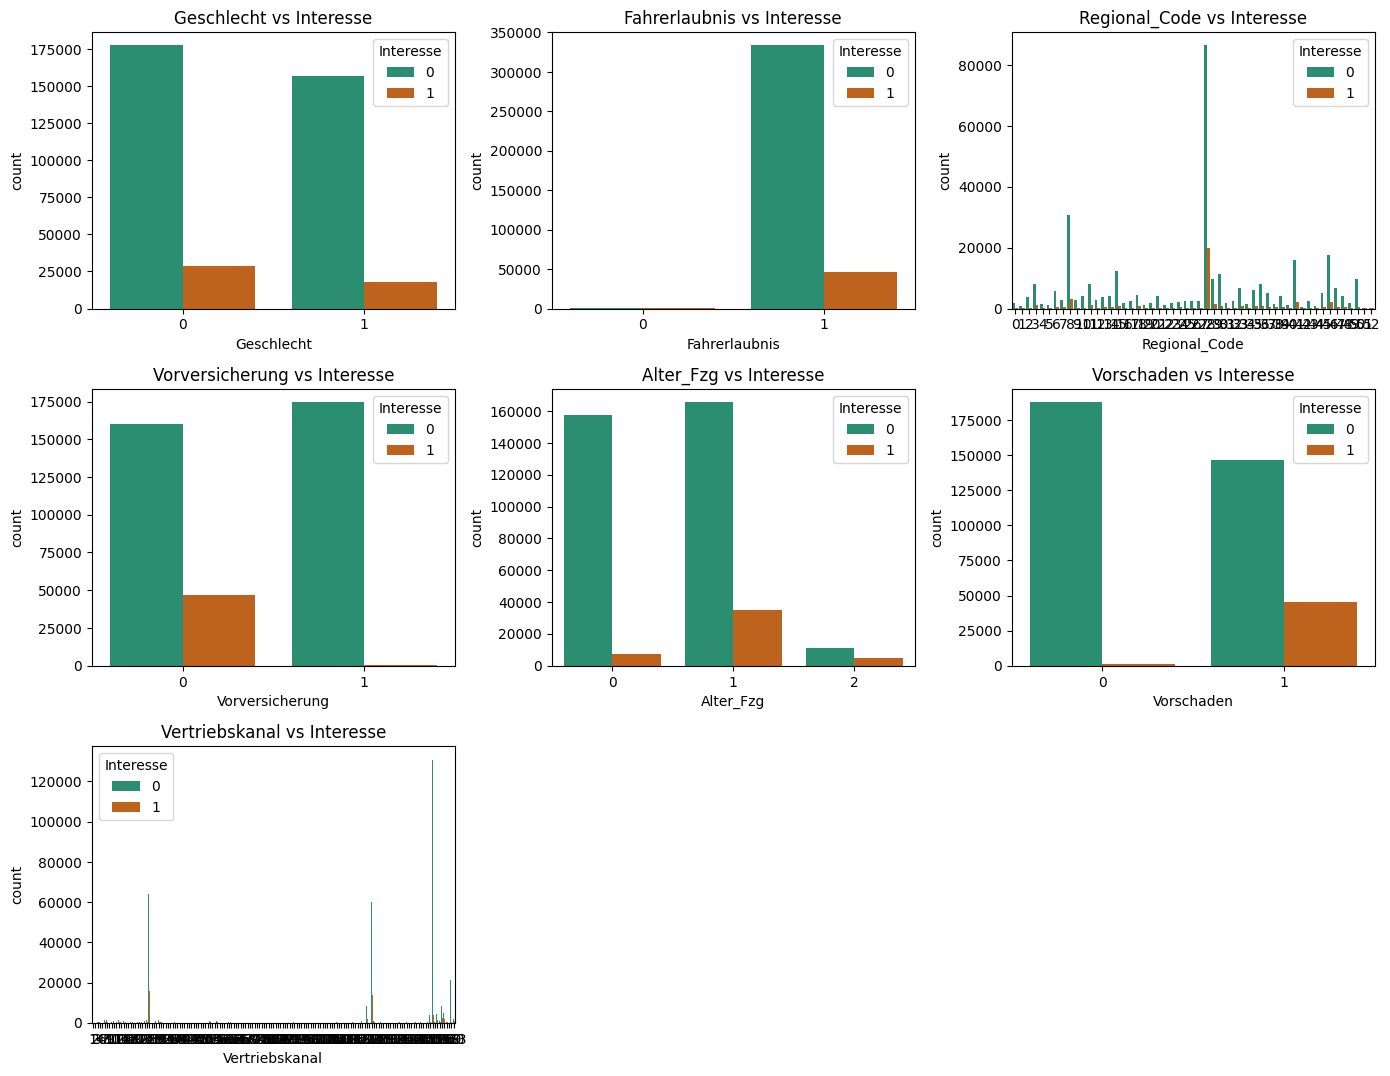

In [16]:
# Code copied from https://www.kaggle.com/code/markuslill/s3e26-xgbclassifer
plt.figure(figsize=(14, len(CAT_FEATS) * 2))
for i, col in enumerate(CAT_FEATS):
    plt.subplot(len(CAT_FEATS) // 2 + 1, 3, i + 1)
    sns.countplot(x=col, hue=LABEL, data=df)
    plt.title(f"{col} vs {LABEL}")
    plt.tight_layout()

**Key overall insights**
- People with no `Vorschaden` are less likely to be interested in an insurance offer ("not faced with the need/benefits"). These might be new (young) drivers or people with a good driving record.
- Only little data availbe for cars with `Age_Fzg` "> 2 Years", seems like only new cars are insured (why?). Might be due to the fact that new cars are more expensive and therefore more likely to be insured.
- There seem to be few `Vertriebskanal`s that are very successful in reaching out to customers (yet not successful in converting them to customers).
- Same for `Regional_Code`s, some regions are more likely to have interested customers.
  - There seems to be one region with a very high interest rate (Region 28), could be because of certain demographics or other factors.

**Assumptions and Questions**
- This might be a "(Voll-)Kasko" insurance data set (since only new cars are insured). This could explain why everyone is already "Kfz-Versicherungskunden" (car insurance customers) since car owner need a minimum insurance ("Kfz-Haftpflich"). HUK wants to offer a new (ontop) insurance service.
- Unclear how the data is sampled. Data description mentions that the people are already "Kfz-Versicherungskunden" (car insurance customers). Does this mean that the data is biased towards people who are already insured? If so, how does this affect the model?
- High active `Vertriebskanal`s might be digital channels (e.g. online ads, social media, etc.). Maybe younger people are more likely to be reached by these channels?

### 03.2 | Numerical Variables

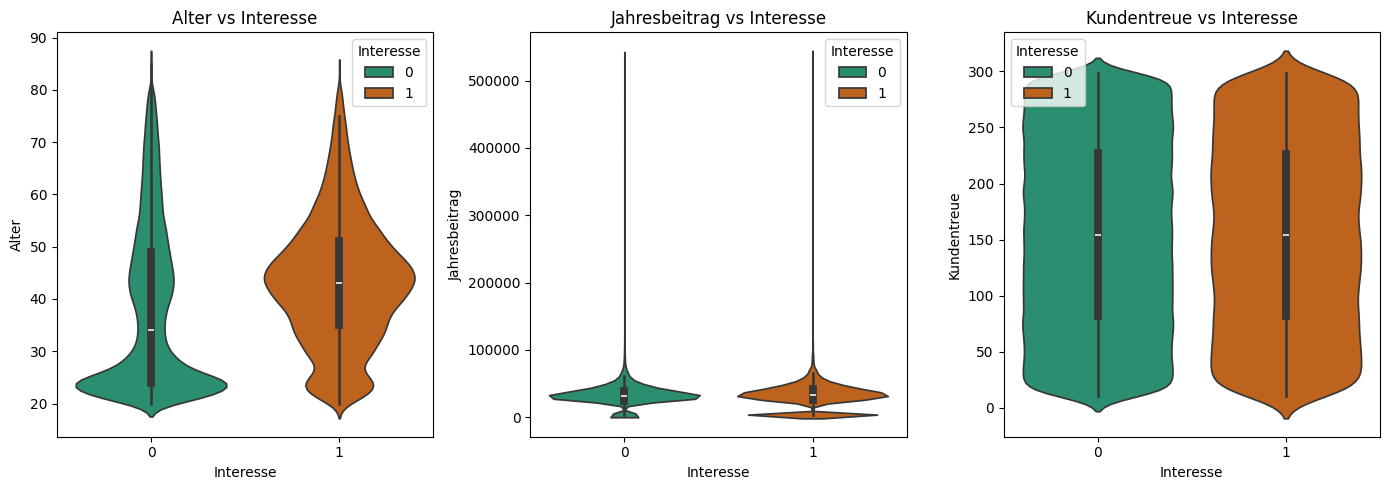

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for i, ax in enumerate(axes.flatten()):
    sns.violinplot(x=LABEL, y=NUM_FEATS[i], data=df, ax=ax, hue=LABEL)
    ax.set_title(f"{NUM_FEATS[i]} vs {LABEL}")
plt.tight_layout()
plt.show()

**Assumptions and Questions**
- High premiums can be explained by very expensive cars (e.g. sports cars, luxury cars, etc.).

Let's analyze the multi-collinearity of the numerical variables.

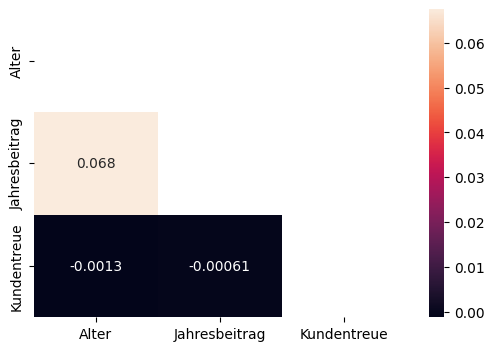

In [9]:
plt.figure(figsize=(6, 4))
mask = np.triu(np.ones_like(df[NUM_FEATS].corr(), dtype=bool))
sns.heatmap(df[NUM_FEATS].corr(), annot=True, mask=mask)
plt.show()

Let's also check the distribution of the numerical variables.

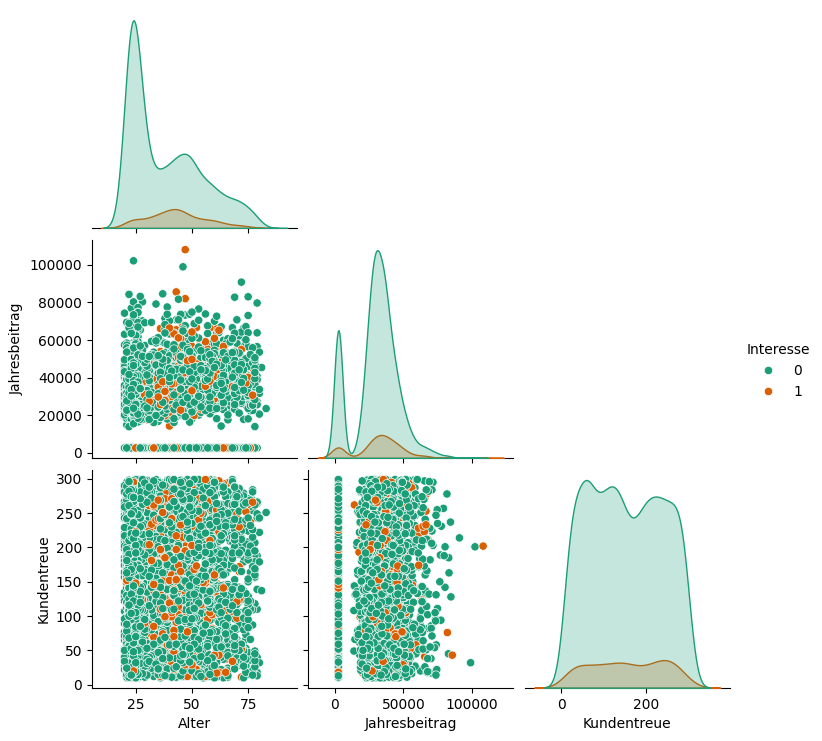

In [10]:
pairplot = sns.pairplot(df[NUM_FEATS + [LABEL]].sample(frac=.01), 
                 hue=LABEL, 
                 corner=True)

## Feature Engineering

In [11]:
def generate_features(df: pd.DataFrame) -> pd.DataFrame:
    # Hypothesis: Customers with no prior insurance but with past damages might have higher interest
    df["Ungedeckter_Vorschaden"] = (df["Vorversicherung"]==0)*(df["Vorschaden"]==1)*1
    # Hypothesis: Older cars might be cheaper to insure, howevere this might interact differently with the premium
    df["Oldtimer_Premium"] = df["Alter_Fzg"] * df["Jahresbeitrag"]
    # Hypothesis: Experienced drivers with a clean record might be less interested in the product
    df["Erfahrene_Fahrer"] = (df["Alter"] > 30) * (df["Fahrerlaubnis"] == 1) * 1
    # Hypothesis: New customers might be more interested in the product
    df["Neukunde"] = df["Kundentreue"] < 30
    # Hypothesis: Young customers with a new car might be more interested in the product
    df["Junges_Fahrzeug"] = (df["Alter"] <= 22) * (df["Alter_Fzg"] == 0) * 1
    # Log transform Jahresbeitrag because it is right skewed (no impact on tree based models)
    df["Log_Jahresbeitrag"] = np.log1p(df["Jahresbeitrag"])
    # Create age bins since year of birth is not very informative
    df["Age_Bins"] = pd.qcut(df["Alter"], q=5, labels=False)
    return df

df = generate_features(df)
df_no_label = generate_features(df_no_label)

DROP_FEATS = ["Log_Jahresbeitrag", "Jahresbeitrag"]

## Model Selection

**What is important, i.e. what should the model optimize?**

I guess it is **less a problem** when we wrongly predict that a customer is interested in an insurance offer. However, it is a **big problem** when we wrongly predict that a customer is not interested in an insurance offer. This is because we might want to reach out to as many interested customers as possible (e.g. through marketing like mail campaigns etc.).

Hence we should optimize for recall (=true positive rate). That means given an interested person we want to have a high probability in identifying her. However, as seen in the EDA the dataset is imbalanced towards the non-interested customers.

**Notes**
- Optimize for recall, while retaining a high/reasonable precision (i.e. not predicting too many false positives)
- Imbalanced dataset (only 12.2% interested customers)

**Insights**
- ✅ `Jahresbeitrag` is an important feature however removing it improves the model performance little bit (reminder: `Jahresbeitrag` might be endogenous)

In [20]:
P_THRESHOLD = 0.001

def recall_eval(y_pred, dtrain):
    """Custom recall evaluation metric for XGBoost"""
    y_true = dtrain.get_label()
    y_pred_label = (y_pred > P_THRESHOLD).astype(int)
    recall = recall_score(y_true, y_pred_label)
    return 'recall', recall

# also define a custom f2 evaluation metric for XGBoost
def f2_eval(y_pred, dtrain):
    """Custom f2 evaluation metric for XGBoost"""
    y_true = dtrain.get_label()
    y_pred_label = (y_pred > P_THRESHOLD).astype(int)
    f2 = fbeta_score(y_true, y_pred_label, beta=2)
    return 'f2', f2

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns=[*DROP_FEATS, LABEL]), df[LABEL], test_size=0.2, random_state=RANDOM_STATE)

# DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eta': 0.1,
    'max_depth': 5,
    'seed': RANDOM_STATE
}

# Train the model with recall monitoring
xgb_cl = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    evals=[(dvalid, 'test')],
    custom_metric=recall_eval,
    maximize=True,
)

[0]	test-logloss:0.36978	test-recall:1.00000
[1]	test-logloss:0.35746	test-recall:1.00000
[2]	test-logloss:0.34690	test-recall:1.00000
[3]	test-logloss:0.33770	test-recall:1.00000
[4]	test-logloss:0.32965	test-recall:1.00000
[5]	test-logloss:0.32263	test-recall:1.00000
[6]	test-logloss:0.31650	test-recall:1.00000
[7]	test-logloss:0.31105	test-recall:1.00000
[8]	test-logloss:0.30629	test-recall:1.00000
[9]	test-logloss:0.30206	test-recall:1.00000
[10]	test-logloss:0.29823	test-recall:1.00000
[11]	test-logloss:0.29489	test-recall:1.00000
[12]	test-logloss:0.29179	test-recall:1.00000
[13]	test-logloss:0.28913	test-recall:1.00000
[14]	test-logloss:0.28678	test-recall:1.00000
[15]	test-logloss:0.28457	test-recall:1.00000
[16]	test-logloss:0.28265	test-recall:1.00000
[17]	test-logloss:0.28100	test-recall:1.00000
[18]	test-logloss:0.27940	test-recall:1.00000
[19]	test-logloss:0.27807	test-recall:1.00000
[20]	test-logloss:0.27686	test-recall:1.00000
[21]	test-logloss:0.27580	test-recall:1.0000

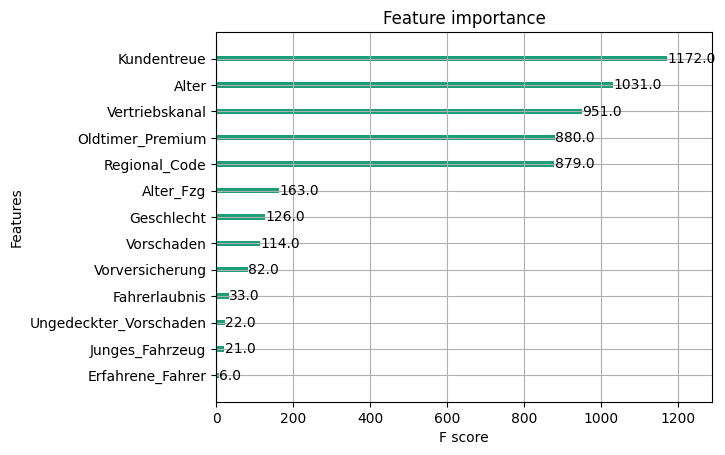

In [23]:
xgb.plot_importance(xgb_cl)

# Store the most important features
important_features = xgb_cl.get_score(importance_type='weight')

Let's get a feeling how the model predicts interest.

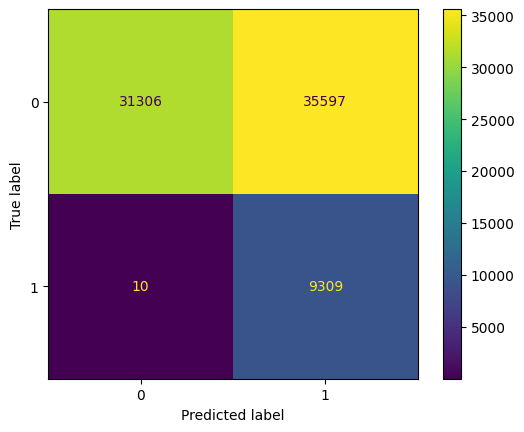

In [24]:
y_pred_prob = xgb_cl.predict(dvalid)
y_pred_label = (y_pred_prob > P_THRESHOLD).astype(int)

cm = confusion_matrix(y_valid, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

The confusion matrix shows that the model is able to predict the interested customers quite well. However, the precision is quite low - a little bit more than half of the non-interested customers are assigned to the interested group. This means that the model predicts >50% false positives. This is at first not a big problem since we want to reach out to as many interested customers as possible, however, this might annoy non-interested customers.

We want to inspect the precision-recall trade-off.

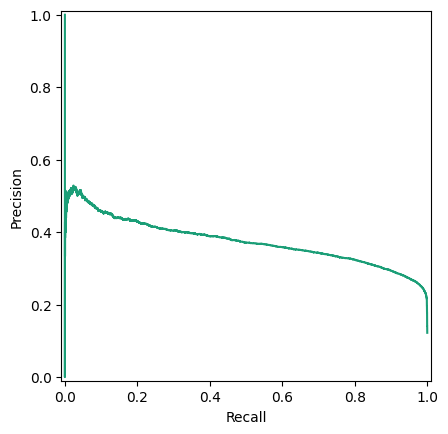

In [14]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
_ = pr_display.plot()

The plot reveals that the model has generally a low precision. However, the precision does not drop significantly when the recall is increased. This is good since we want to have a high recall while retaining a high precision.

## Create test submission file

Since we assume that the missing values in the interest dataframe are the test data, we can create a submission file with the same length as the interest dataframe.

In [15]:
dtest = xgb.DMatrix(df_no_label.drop(columns=DROP_FEATS))
y_pred_no_label = xgb_cl.predict(dtest)

df_submission = pd.DataFrame({"id": df_no_label_ids, LABEL: y_pred_no_label}).sort_values("id").reset_index(drop=True)
df_submission


,id,Interesse
0,381110,0.000699
1,381111,0.325138
2,381112,0.305196
3,381113,0.006539
4,381114,0.000492
...,...,...
127032,508142,0.000278
127033,508143,0.367582
127034,508144,0.000332
127035,508145,0.000245
